# **Capstone project: Providing data-driven suggestions for HR**

### Familiarize yourself with the HR dataset 

In this [dataset](https://www.kaggle.com/datasets/mfaisalqureshi/hr-analytics-and-job-prediction?select=HR_comma_sep.csv), there are 14,999 rows, 10 columns, and these variables: 

Variable  |Description |
-----|-----| 
satisfaction_level|Employee-reported job satisfaction level [0&ndash;1]|
last_evaluation|Score of employee's last performance review [0&ndash;1]|
number_project|Number of projects employee contributes to|
average_monthly_hours|Average number of hours employee worked per month|
time_spend_company|How long the employee has been with the company (years)
Work_accident|Whether or not the employee experienced an accident while at work
left|Whether or not the employee left the company
promotion_last_5years|Whether or not the employee was promoted in the last 5 years
Department|The employee's department
salary|The employee's salary (U.S. dollars)

## Step 1. Imports

*   Import packages
*   Load dataset



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree
import pickle
import warnings

### Load dataset

In [2]:
df = pd.read_csv("HR_capstone_dataset.csv")
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


## Step 2. Data Exploration (Initial EDA and data cleaning)

- Understand variables
- Clean dataset (missing data, redundant data, outliers) 



In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [4]:
df.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


### Rename columns

In [5]:
df = df.rename(columns={'Work_accident': 'work_accident',
                          'average_montly_hours': 'average_monthly_hours',
                          'time_spend_company': 'tenure',
                          'Department': 'department'})

### Check missing values

In [6]:
df.isna().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_monthly_hours    0
tenure                   0
work_accident            0
left                     0
promotion_last_5years    0
department               0
salary                   0
dtype: int64

### Check duplicates

In [7]:
df.duplicated().sum()

np.int64(3008)

3,008 rows contain duplicates.

In [8]:
df[df.duplicated()].head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,department,salary
396,0.46,0.57,2,139,3,0,1,0,sales,low
866,0.41,0.46,2,128,3,0,1,0,accounting,low
1317,0.37,0.51,2,127,3,0,1,0,sales,medium
1368,0.41,0.52,2,132,3,0,1,0,RandD,low
1461,0.42,0.53,2,142,3,0,1,0,sales,low


With several continuous variables across 10 columns, it seems very unlikely that these duplicate entries are legitimate (2 employees have the exact same values for each column, which seems highly unlikely), so we will drop them.

In [9]:
df1 = df.drop_duplicates(keep='first')
df1.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


### Check outliers

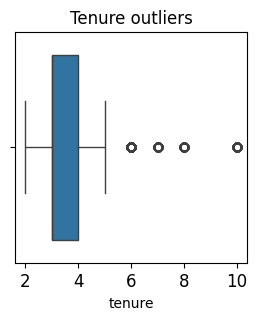

In [10]:
plt.figure(figsize=(3,3))
plt.title('Tenure outliers', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x=df1['tenure'])
plt.show()

Investigate how many rows in the data contain outliers in the tenure column.

In [11]:
# Determine the number of rows containing outliers 

# Compute the 25th percentile value in `tenure` (lower limit of box plot)
per25 = df1['tenure'].quantile(0.25)

# Compute the 75th percentile value in `tenure` (upper limit of box plot)
per75 = df1['tenure'].quantile(0.75)

# Compute the interquartile range in `tenure` (upper - lower)
iqr = per75 - per25

# Calculate upper and lower thresholds for non-outliers in 'tenure'
upper_limit = per75 + 1.5 * iqr
lower_limit = per25 - 1.5 * iqr
print("Upper limit: ",upper_limit)
print("Lower limit: ",lower_limit)

# Identify subset of data containing outliers in `tenure` (all outliers together) and show how many outliers total
outliers = df1[(df1['tenure'] > upper_limit) | (df1['tenure'] < lower_limit)]
print("Total outliers: ",len(outliers))

Upper limit:  5.5
Lower limit:  1.5
Total outliers:  824


We will consider whether to remove these outliers based on the type of model we use.

## Step 2. Data Exploration 
Begin by understanding how many employees left and what percentage of all employees this figure represents.

In [12]:
# Get numbers of people who left vs. stayed
print(df1['left'].value_counts())
print()

# Get percentages of people who left vs. stayed
print(df1['left'].value_counts(normalize=True))

left
0    10000
1     1991
Name: count, dtype: int64

left
0    0.833959
1    0.166041
Name: proportion, dtype: float64


### Data visualizations

Stacked boxplot showing `average_monthly_hours` distributions for `number_project`. Left = orange, stayed = blue.

Stacked histogram to visualize the distribution of `number_project`.

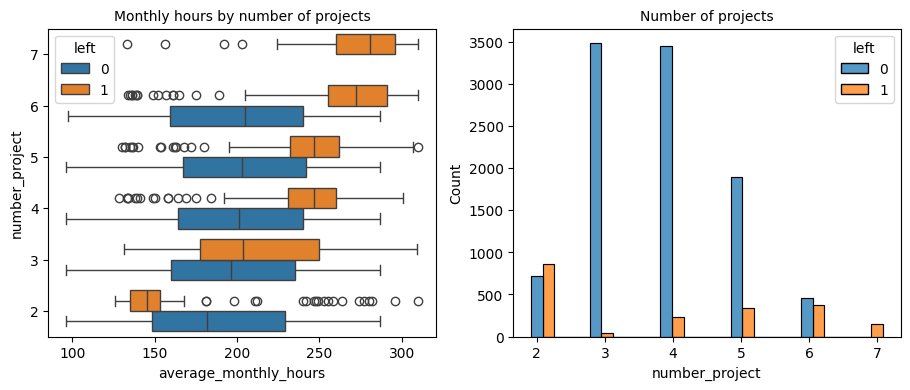

In [13]:
fig, ax = plt.subplots(1, 2, figsize = (11,4))
sns.boxplot(data=df1, x='average_monthly_hours', y='number_project', hue='left', orient="h", ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Monthly hours by number of projects', fontsize='10')
tenure_stay = df1[df1['left']==0]['number_project']
tenure_left = df1[df1['left']==1]['number_project']
sns.histplot(data=df1, x='number_project', hue='left', multiple='dodge', shrink=2, ax=ax[1])
ax[1].set_title('Number of projects', fontsize='10')
plt.show()

In [14]:
df1[df1['number_project']==7]['left'].value_counts()

left
1    145
Name: count, dtype: int64

1. People who work on more projects work longer hours.

2. All 145 employees with seven projects left the company.

3. The optimal number of projects for employees to work on seems to be 3.


Examine the average monthly hours versus the satisfaction levels. 40 hour work week with 2 weeks off per year = 166.67 hrs/month.

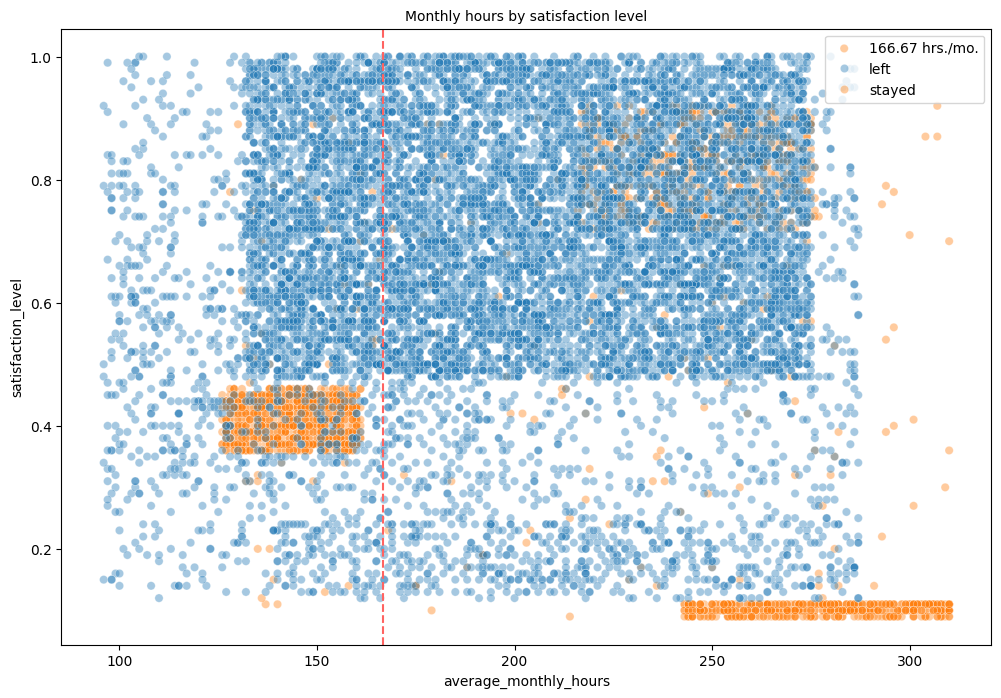

In [15]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df1, x='average_monthly_hours', y='satisfaction_level', hue='left', alpha=0.4)
plt.axvline(x=166.67, color='#ff6361', label='166.67 hrs./mo.', ls='--')
plt.legend(labels=['166.67 hrs./mo.', 'left', 'stayed'])
plt.title('Monthly hours by satisfaction level', fontsize='10');

- The scatterplot above shows that there was a sizeable group of employees who worked ~240&ndash;320 hours per month. This is around 60-80 hours a week. This group of overworked employees are shown to have the lowest satisfaction levels, which makes sense.
- Another group of employees that left worked 120-160 hours per month. This is 30-40 hours per week which are retgular working hours. It is unkown as of now why that left.
- There is a group who worked ~210&ndash;280 hours per month. This is 52.5-70 hours per week, with satisfaction levels ranging ~0.7&ndash;0.9. 
- There is a correlation between satisfaction level and hours worked.

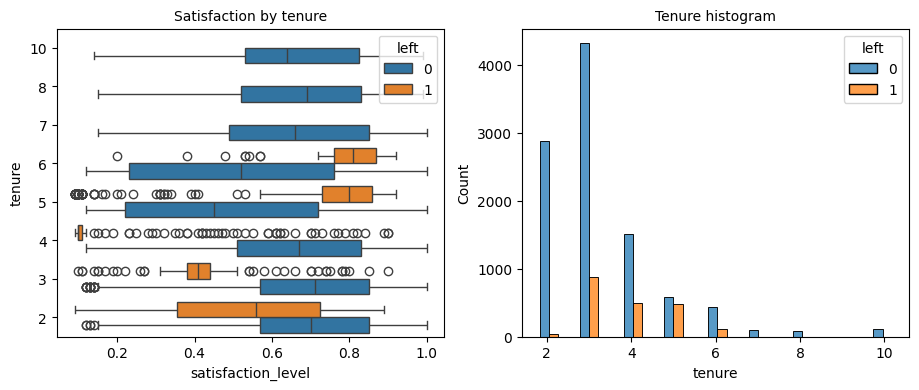

In [16]:
# Check satisfaction by tenure

fig, ax = plt.subplots(1, 2, figsize = (11,4))
sns.boxplot(data=df1, x='satisfaction_level', y='tenure', hue='left', orient="h", ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Satisfaction by tenure', fontsize='10')
tenure_stay = df1[df1['left']==0]['tenure']
tenure_left = df1[df1['left']==1]['tenure']
sns.histplot(data=df1, x='tenure', hue='left', multiple='dodge', shrink=5, ax=ax[1])
ax[1].set_title('Tenure histogram', fontsize='10')
plt.show();

There are many observations you could make from this plot.
- Employees who left have satisfaction levels of 0.35-0.7 with a tenure of approximately 2. Also those with satisfaction of 0.7-0.8 with tenure 5-6.
- The longest-tenured employees didn't leave. 
- The histogram shows that there are relatively few longer-tenured employees. It's possible that they're higher-paid employees.

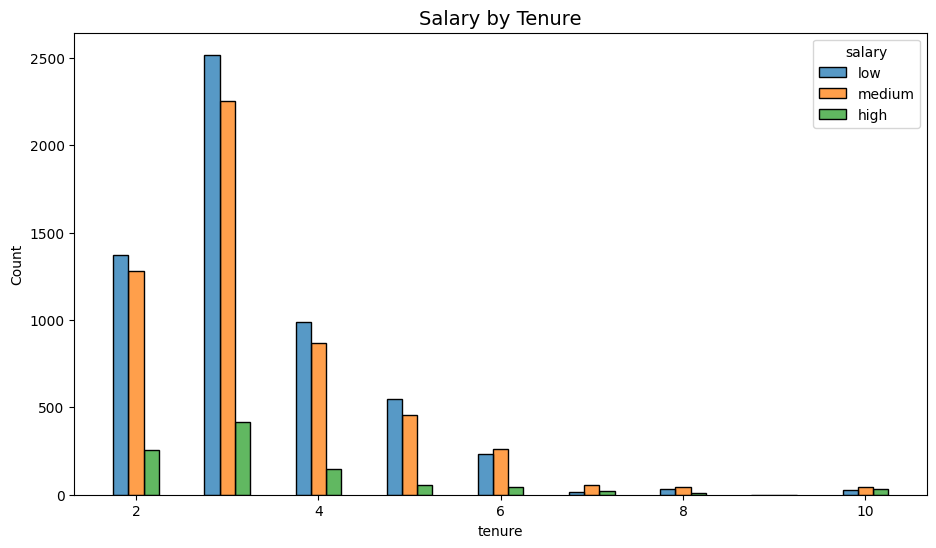

In [17]:
# Salary for different tenures
plt.figure(figsize=(11,6))
sns.histplot(data=df1, x='tenure', hue='salary', discrete=1, 
             hue_order=['low', 'medium', 'high'], multiple='dodge', shrink=.5)
plt.title('Salary by Tenure', fontsize=14);


Next, correlation between working long hours and receiving high evaluation scores.

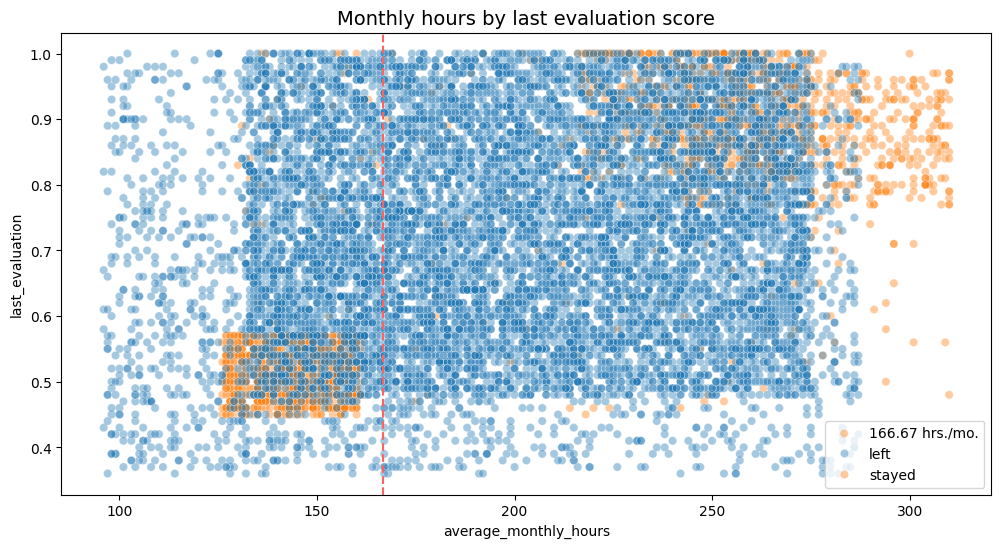

In [18]:

plt.figure(figsize=(12, 6))
sns.scatterplot(data=df1, x='average_monthly_hours', y='last_evaluation', hue='left', alpha=0.4)
plt.axvline(x=166.67, color='#ff6361', label='166.67 hrs./mo.', ls='--')
plt.legend(labels=['166.67 hrs./mo.', 'left', 'stayed'])
plt.title('Monthly hours by last evaluation score', fontsize='14');

The following observations can be made from the scatterplot above:
- Overworked employee group who performed very well (eval = 0.8-1)
- Employee group who worked under the monthly average (eval = 0.45-0.55)
- There seems to be a correlation between hours worked and evaluation score. 
- Working long hours doesn't guarantee a good evaluation score.
- Most of the employees in this company work well over the monthly average.

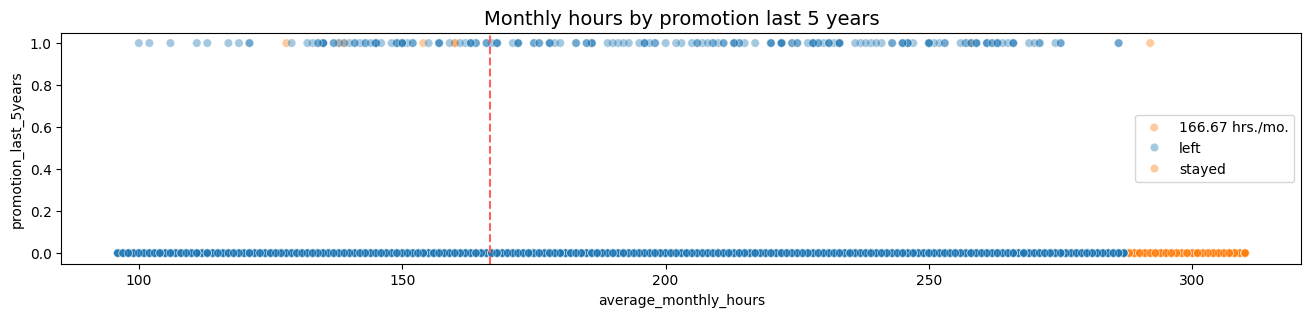

In [19]:
# Examine whether employees who worked very long hours were promoted in the last five years.

plt.figure(figsize=(16, 3))
sns.scatterplot(data=df1, x='average_monthly_hours', y='promotion_last_5years', hue='left', alpha=0.4)
plt.axvline(x=166.67, color='#ff6361', ls='--')
plt.legend(labels=['166.67 hrs./mo.', 'left', 'stayed'])
plt.title('Monthly hours by promotion last 5 years', fontsize='14');

The plot above shows the following:
- 4 employees who were promoted in the last five years left.
- Most employees who worked the most hours were not promoted (most are still on 0 = no promotion).
- All employees who left were working the longest hours.  


In [20]:
# Display counts for each department
df1["department"].value_counts()

department
sales          3239
technical      2244
support        1821
IT              976
RandD           694
product_mng     686
marketing       673
accounting      621
hr              601
management      436
Name: count, dtype: int64

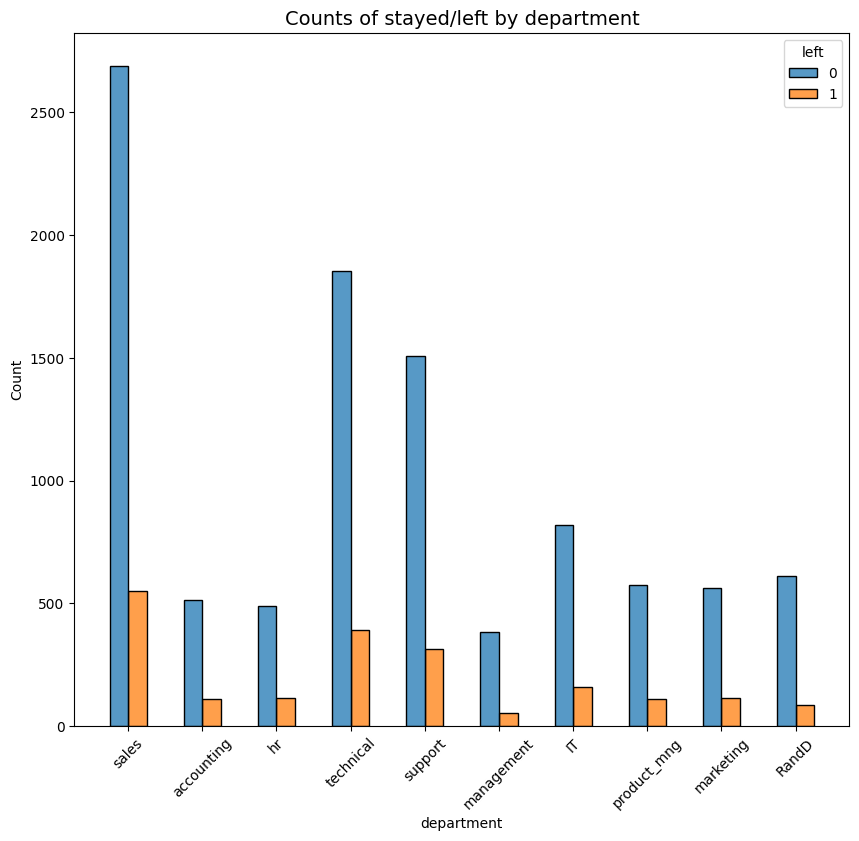

In [21]:
# Create stacked histogram to compare department distribution of employees who left to that of employees who didn't
plt.figure(figsize=(10,9))
sns.histplot(data=df1, x='department', hue='left', discrete=1, 
             hue_order=[0, 1], multiple='dodge', shrink=.5)
plt.xticks(rotation=45)
plt.title('Counts of stayed/left by department', fontsize=14);


Each department has similar proportion of stayed to left.

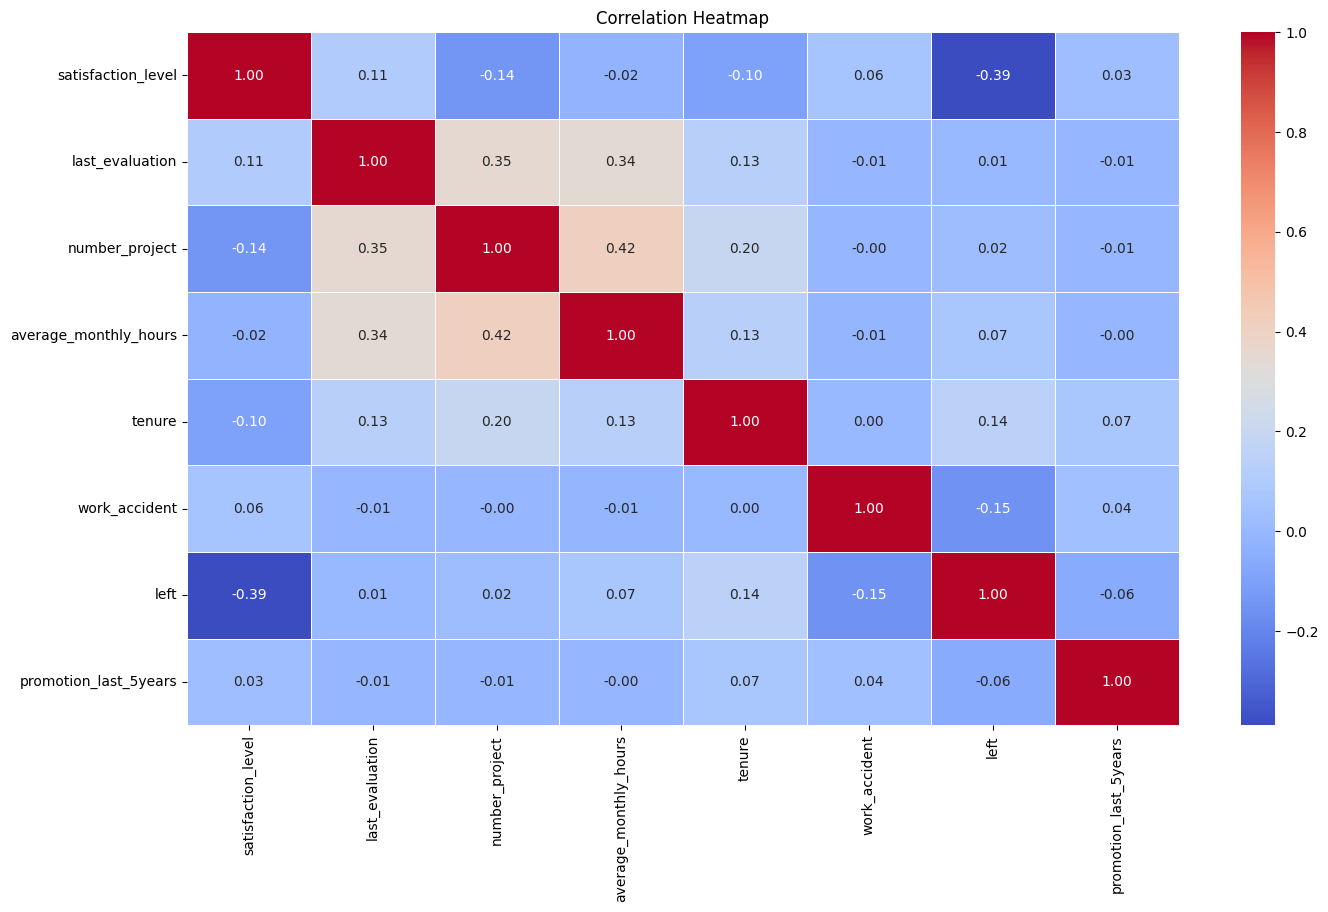

In [22]:
# Check for strong correlations with heatmap

#only include numeric value columns, drop departmen and salary
df_num = df.drop(columns=['department','salary'])

plt.figure(figsize=(16, 9))
sns.heatmap(df_num.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

Positive correlations between last evaluation, average monthly working hours, and number of projects. An employee leaving is negativelly correlated to satisfaction level (the more leave, the least satisfied).

🔎
## Step 3. Build logistic regression model and tree-based model, check assumptions and evaluate

**Check model assumptions of logistic**
- Outcome variable is categorical ('left')
- Independent observations
- No severe multicollinearity among X variables 
- No extreme outliers
- Linear relationship between each X variable and the logit of the outcome variable





Encode `department` as dummy variables and `salary` to 0-2 since it is ordinal categorical

In [23]:
# Copy the dataframe
df_enc = df1.copy()

# Encode the `salary` column as an ordinal numeric category
df_enc['salary'] = (df_enc['salary'].astype('category').cat.set_categories(['low', 'medium', 'high']).cat.codes)

# Dummy encode the `department` column
df_enc = pd.get_dummies(df_enc, drop_first=False)

df_enc.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
1,0.80,0.86,5,262,6,0,1,0,1,False,False,False,False,False,False,False,True,False,False
2,0.11,0.88,7,272,4,0,1,0,1,False,False,False,False,False,False,False,True,False,False
3,0.72,0.87,5,223,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False
4,0.37,0.52,2,159,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False


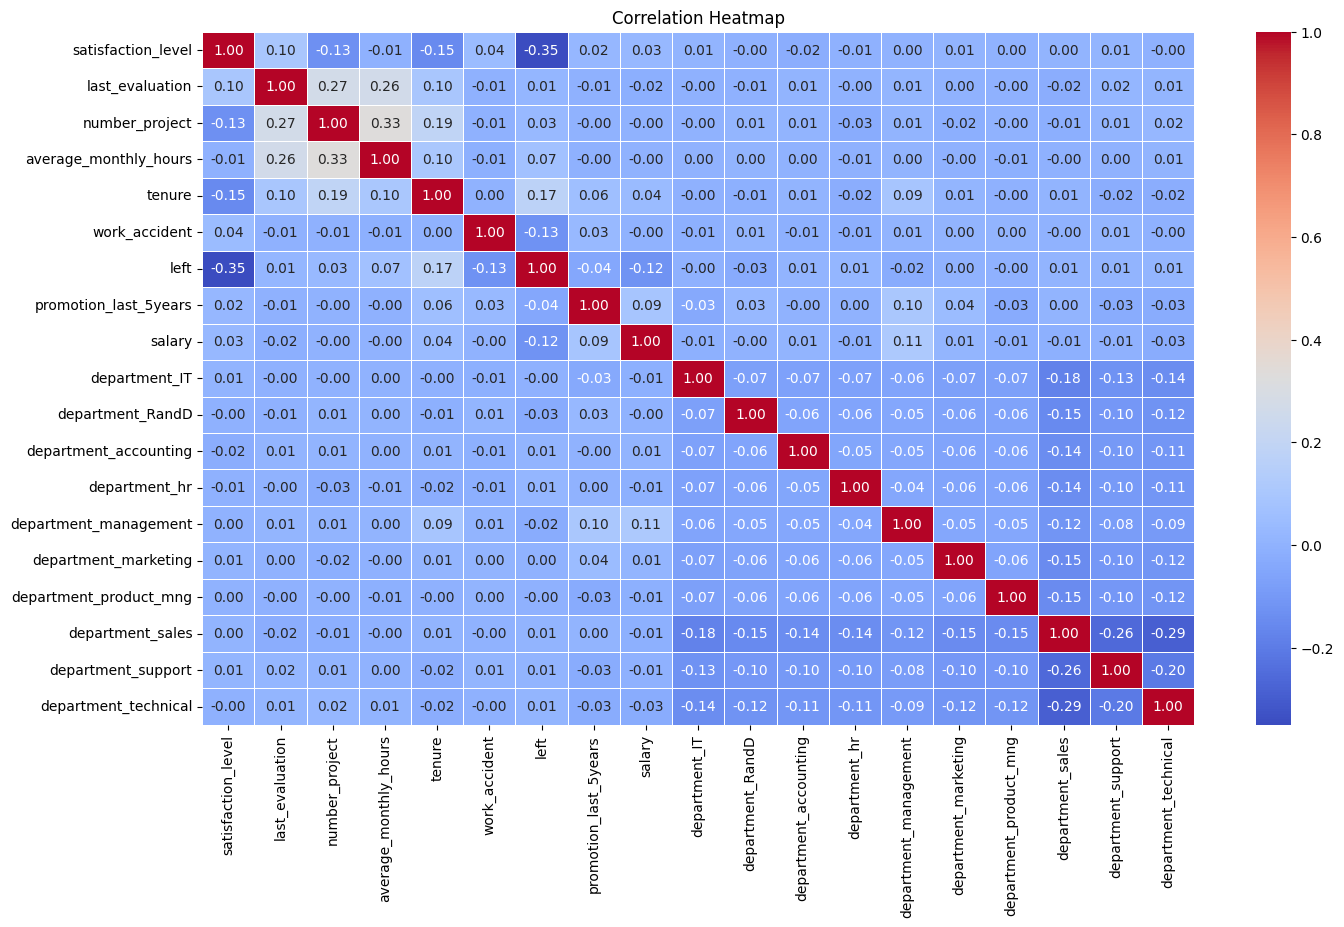

In [24]:
# Create a heatmap to visualize how correlated variables are
plt.figure(figsize=(16, 9))
sns.heatmap(df_enc.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

Since logistic regression is quite sensitive to outliers, it would be a good idea at this stage to remove the outliers in the `tenure` column that were identified earlier.

In [25]:
# Select rows without outliers in `tenure`
df_logreg = df_enc[(df_enc['tenure'] >= lower_limit) & (df_enc['tenure'] <= upper_limit)]
df_logreg.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
2,0.11,0.88,7,272,4,0,1,0,1,False,False,False,False,False,False,False,True,False,False
3,0.72,0.87,5,223,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False
4,0.37,0.52,2,159,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
5,0.41,0.50,2,153,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False


In [26]:
# Isolate prediction variable 'left'
y = df_logreg['left']
y.head() 

0    1
2    1
3    1
4    1
5    1
Name: left, dtype: int64

In [27]:
# Select the features to use 
X = df_logreg.drop('left', axis=1)
X.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,0,0,False,False,False,False,False,False,False,True,False,False
2,0.11,0.88,7,272,4,0,0,1,False,False,False,False,False,False,False,True,False,False
3,0.72,0.87,5,223,5,0,0,0,False,False,False,False,False,False,False,True,False,False
4,0.37,0.52,2,159,3,0,0,0,False,False,False,False,False,False,False,True,False,False
5,0.41,0.50,2,153,3,0,0,0,False,False,False,False,False,False,False,True,False,False


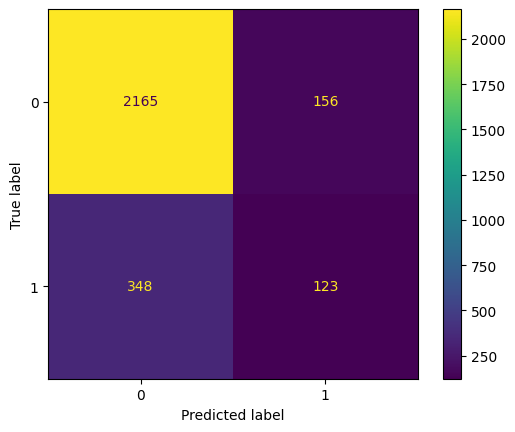

In [28]:
# Split the data into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# Construct a logistic regression model and fit it to the training dataset
log_clf = LogisticRegression(random_state=42, max_iter=500).fit(X_train, y_train)

# Get predictions on the test set
y_pred = log_clf.predict(X_test)

# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred, labels=log_clf.classes_)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, 
                                  display_labels=log_clf.classes_)

# Plot confusion matrix
log_disp.plot(values_format='')

# Display plot
plt.show()

2165 employees who did not leave the model were accurately predicted as not leaving.

156 employees who did not leave the model were inaccurately predicted as leaving.

348 employees who left the model inaccurately predicted as not leaving.

123 employees who left the model accurately predicted as leaving.


Check the class balance in the data and evaluate the performance of this model with precision, recall, f1-score and accuracy.

In [29]:
df_logreg['left'].value_counts(normalize=True)

left
0    0.831468
1    0.168532
Name: proportion, dtype: float64

There is an approximately 83%-17% split. So the data is not perfectly balanced, but it is not too imbalanced. No need to modify data.

In [30]:
# Create classification report for logistic regression model
targets = ['Predicted would not leave', 'Predicted would leave']
print(classification_report(y_test, y_pred, target_names=targets))

                           precision    recall  f1-score   support

Predicted would not leave       0.86      0.93      0.90      2321
    Predicted would leave       0.44      0.26      0.33       471

                 accuracy                           0.82      2792
                macro avg       0.65      0.60      0.61      2792
             weighted avg       0.79      0.82      0.80      2792



The mmodel achieved a precision of 79%, recall of 82%, f1-score of 80% as the weighted averages.

### Modeling Approach B: Tree-based Model
We will use the same outcome variable, features, and data splitting as defined above, so no need to re-code

#### Decision tree 

In [31]:
tree = DecisionTreeClassifier(random_state=0)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth':[4, 6, 8, None],
             'min_samples_leaf': [2, 5, 1],
             'min_samples_split': [2, 4, 6]
             }

scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

tree1 = GridSearchCV(tree, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [32]:
%%time
# Fit into data
tree1.fit(X_train, y_train)

CPU times: total: 4.03 s
Wall time: 4.08 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [33]:
# Check best parameters
tree1.best_params_

{'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2}

In [34]:
# Check best AUC score on CV
tree1.best_score_

np.float64(0.9738070859906354)

The model therefore can predict employees who will leave nicely with this high AUC score, since being 1 equates to a perfect classifier and 0.5 is equivalent to random guessing.

In [35]:
def make_results(model_name: str, model_object, metric: str) -> pd.DataFrame:
    """
    Generates a results summary for a fitted GridSearchCV model based on the specified scoring metric.

    Parameters:
        model_name (str): Name to assign to the model in the output.
        model_object: A fitted GridSearchCV object.
        metric (str): Metric to optimize ('precision', 'recall', 'f1', 'accuracy', or 'auc').

    Returns:
        pd.DataFrame: A single-row DataFrame with scores for precision, recall, F1, accuracy, and AUC.
    """

    metric_dict = {
        'auc': 'mean_test_roc_auc',
        'precision': 'mean_test_precision',
        'recall': 'mean_test_recall',
        'f1': 'mean_test_f1',
        'accuracy': 'mean_test_accuracy'
    }

    if metric not in metric_dict:
        raise ValueError(f"Invalid metric '{metric}'. Choose from: {list(metric_dict.keys())}")

    # Get all cross-validation results
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Get row with the best score for the specified metric
    best_idx = cv_results[metric_dict[metric]].idxmax()
    best_row = cv_results.loc[best_idx]

    # Extract relevant scores
    results = {
        'model': model_name,
        'precision': best_row.get('mean_test_precision', None),
        'recall': best_row.get('mean_test_recall', None),
        'F1': best_row.get('mean_test_f1', None),
        'accuracy': best_row.get('mean_test_accuracy', None),
        'auc': best_row.get('mean_test_roc_auc', None)
    }

    return pd.DataFrame([results])

Use the function just defined to get all the scores from grid search.

In [36]:
# Get all CV scores
tree1_cv_results = make_results('decision tree cv', tree1, 'auc')
tree1_cv_results

,model,precision,recall,F1,accuracy,auc
0,decision tree cv,0.959115,0.912839,0.935275,0.978747,0.973807


#### Random forest 

In [49]:
from sklearn.model_selection import RandomizedSearchCV  #this speeds it up
# Base model
rf = RandomForestClassifier(random_state=0)

# Reduce combinations by narrowing the grid
cv_params = {'max_depth': [3,5, None], 
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2],
             'min_samples_split': [2,3],
             'n_estimators': [300],
             }  

# Scoring metrics
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Optimized GridSearchCV
rf1 = GridSearchCV(
    estimator=rf,
    param_grid=cv_params,
    scoring=scoring,
    refit='roc_auc',
    cv=3,               
)

# Fit the model
rf1.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3], 'n_estimators': [300]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [39]:
# Define a path to the folder to save the model
from pathlib import Path
path = r"C:\Users\User\Desktop\Files (1)"

In [40]:
def write_pickle(path, model_object, save_as: str):
    """
    Saves a model object to a specified path using pickle.
    """
    path = Path(path)
    path.mkdir(parents=True, exist_ok=True) 
    file_path = path / f"{save_as}.pickle"

    with file_path.open('wb') as f:
        pickle.dump(model_object, f)


def read_pickle(path, saved_model_name: str):
    """
    Loads a pickled model object from the specified path.
    """
    path = Path(path)
    file_path = path / f"{saved_model_name}.pickle"

    with file_path.open('rb') as f:
        model = pickle.load(f)

    return model

Use the functions defined above to save the model in a pickle file and then read it in.

In [42]:
write_pickle(path, rf1, 'hr_rf1')

In [41]:
rf1 = read_pickle(path, 'hr_rf1')

In [50]:
# Check best AUC score on CV
rf1.best_score_

np.float64(0.9814449522012364)

In [51]:
# Check best paramaters in random forest
rf1.best_params_

{'max_depth': 5,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}

Collect the evaluation scores on the training set for the decision tree and random forest models.

In [52]:
# Get all CV scores
rf1_cv_results = make_results('random forest cv', rf1, 'auc')
print(tree1_cv_results)
print(rf1_cv_results)

              model  precision    recall        F1  accuracy       auc
0  decision tree cv   0.959115  0.912839  0.935275  0.978747  0.973807
              model  precision    recall        F1  accuracy       auc
0  random forest cv   0.966238  0.912835  0.938725  0.979941  0.981445


Random forest performs better than the decision tree.


Define a function that gets all the scores from a model's predictions.

In [53]:
def get_scores(model_name:str, model, X_test_data, y_test_data):
    '''
    In: 
        model_name (string):  How you want your model to be named in the output table
        model:                A fit GridSearchCV object
        X_test_data:          numpy array of X_test data
        y_test_data:          numpy array of y_test data

    Out: pandas df of precision, recall, f1, accuracy, and AUC scores for your model
    '''

    preds = model.best_estimator_.predict(X_test_data)

    auc = roc_auc_score(y_test_data, preds)
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision], 
                          'recall': [recall],
                          'f1': [f1],
                          'accuracy': [accuracy],
                          'AUC': [auc]
                         })
  
    return table
# Get predictions on test data
rf1_test_scores = get_scores('random forest1 test', rf1, X_test, y_test)
rf1_test_scores

,model,precision,recall,f1,accuracy,AUC
0,random forest1 test,0.982063,0.929936,0.955289,0.985315,0.963245


The test scores are very similar to the validation scores, which is good. This appears to be a strong model.

#### Feature Engineering

The first round of decision tree and random forest models included all variables as features. This next round will incorporate feature engineering to build improved models. 

Drop `satisfaction_level` and create a new feature that captures whether an employee is overworked  `overworked`. It will be a binary variable.

In [54]:
df2 = df_enc.drop('satisfaction_level', axis=1)
df2.head()

,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.53,2,157,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
1,0.86,5,262,6,0,1,0,1,False,False,False,False,False,False,False,True,False,False
2,0.88,7,272,4,0,1,0,1,False,False,False,False,False,False,False,True,False,False
3,0.87,5,223,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False
4,0.52,2,159,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False


In [55]:
# Create `overworked` column. For now, it's identical to average monthly hours.
df2['overworked'] = df2['average_monthly_hours']

print('Max hours:', df2['overworked'].max())
print('Min hours:', df2['overworked'].min())

Max hours: 310
Min hours: 96


166.67 is approximately the average number of monthly hours for someone who works 50 weeks per year, 5 days per week, 8 hours per day. 

You could define being overworked as working more than 175 hours per month on average.

Make the `overworked` column binary using a boolean mask.
- `df3['overworked'] > 175` creates a series of booleans, consisting of `True` for every value > 175 and `False` for every values ≤ 175
- `.astype(int)` converts all `True` to `1` and all `False` to `0` 

In [56]:
df2['overworked'] = (df2['overworked'] > 175).astype(int)
df2['overworked'].head()

0    0
1    1
2    1
3    1
4    0
Name: overworked, dtype: int64

In [57]:
# Drop the `average_monthly_hours` column
df2 = df2.drop('average_monthly_hours', axis=1)
df2.head()

,last_evaluation,number_project,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,overworked
0,0.53,2,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False,0
1,0.86,5,6,0,1,0,1,False,False,False,False,False,False,False,True,False,False,1
2,0.88,7,4,0,1,0,1,False,False,False,False,False,False,False,True,False,False,1
3,0.87,5,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False,1
4,0.52,2,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False,0


In [58]:
# Isolate the outcome variable and select feature
y = df2['left']
X = df2.drop('left', axis=1)

# Create test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=0)

#### Decision tree 2

In [59]:
tree = DecisionTreeClassifier(random_state=0)
cv_params = {'max_depth':[4, 6, 8, None],
             'min_samples_leaf': [2, 5, 1],
             'min_samples_split': [2, 4, 6]
             }

scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
tree2 = GridSearchCV(tree, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [ ]:
%%time
tree2.fit(X_train, y_train)

In [ ]:
# Check best params
tree2.best_params_

{'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 6}

In [ ]:
# Check best AUC score on CV
tree2.best_score_

np.float64(0.9586752505340426)

This model performs very well, even without satisfaction levels and detailed hours worked data. 

Next, check the other scores.

In [ ]:
# Get all CV scores
tree2_cv_results = make_results('decision tree2 cv', tree2, 'auc')
print(tree1_cv_results)
print(tree2_cv_results)

              model  precision    recall        F1  accuracy       auc
0  decision tree cv   0.959115  0.912839  0.935275  0.978747  0.973807
               model  precision    recall        F1  accuracy       auc
0  decision tree2 cv   0.856693  0.903553  0.878882  0.958523  0.958675


Some of the other scores fell. That's to be expected given fewer features were taken into account in this round of the model. Still, the scores are very good.

#### Random forest 2

In [ ]:

rf = RandomForestClassifier(random_state=0)
cv_params = {'max_depth': [3,5, None], 
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [300, 500],
             }  

scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
rf2 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [ ]:
%%time
rf2.fit(X_train, y_train) # --> Wall time: 7min 5s

CPU times: total: 16min 55s
Wall time: 16min 56s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 500]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [ ]:
# Write pickle
write_pickle(path, rf2, 'hr_rf2')

In [ ]:
# Read in pickle
rf2 = read_pickle(path, 'hr_rf2')
rf2.best_params_

{'max_depth': 5,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}

In [ ]:
# Check best AUC score on CV
rf2.best_score_

np.float64(0.9648100662833985)

In [ ]:
# Get all CV scores to compare tree and forest
rf2_cv_results = make_results('random forest2 cv', rf2, 'auc')
print(tree2_cv_results)
print(rf2_cv_results)

               model  precision    recall        F1  accuracy       auc
0  decision tree2 cv   0.856693  0.903553  0.878882  0.958523  0.958675
               model  precision    recall        F1  accuracy      auc
0  random forest2 cv   0.866758  0.878754  0.872407  0.957411  0.96481


Again, the scores dropped slightly, but the random forest performs better than the decision tree if using AUC as the deciding metric. 

Score the champion model on the test set now.

In [ ]:
# Get predictions on test data
rf2_test_scores = get_scores('random forest2 test', rf2, X_test, y_test)
rf2_test_scores

,model,precision,recall,f1,accuracy,AUC
0,random forest2 test,0.870406,0.903614,0.8867,0.961641,0.938407


This seems to be a stable, well-performing final model. 

Plot a confusion matrix to visualize how well it predicts on the test set.

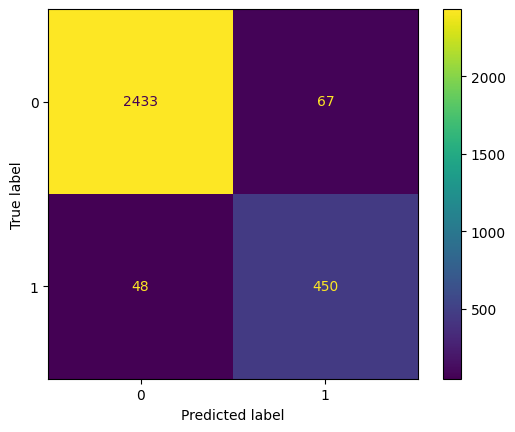

In [ ]:
# Generate array of values for confusion matrix
preds = rf2.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, preds, labels=rf2.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=rf2.classes_)
disp.plot(values_format='');

The model predicts more false positives than false negatives, which means that some employees may be identified as at risk of quitting or getting fired, when that's actually not the case. But this is still a strong model.

For exploratory purpose, you might want to inspect the splits of the decision tree model and the most important features in the random forest model. 

#### Decision tree splits

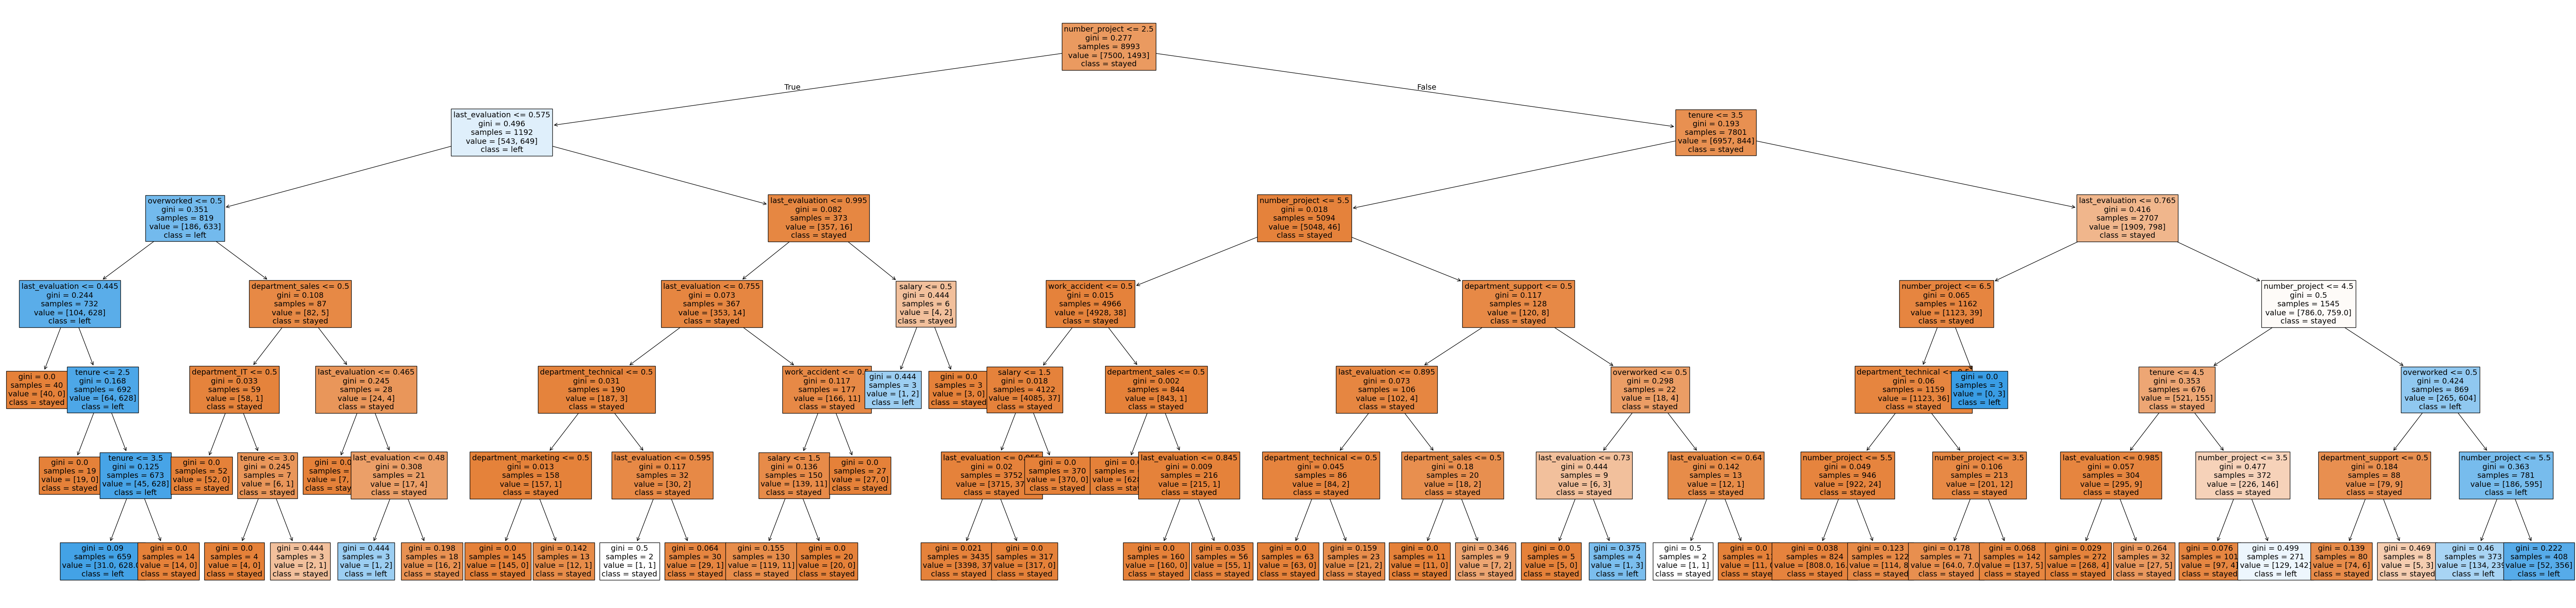

In [ ]:
# Plot the tree
plt.figure(figsize=(85,20))
plot_tree(tree2.best_estimator_, max_depth=6, fontsize=14, feature_names=X.columns, 
          class_names={0:'stayed', 1:'left'}, filled=True);
plt.show()

#### Decision tree feature importance

In [ ]:

tree2_importances = pd.DataFrame(tree2.best_estimator_.feature_importances_, 
                                 columns=['gini_importance'], 
                                 index=X.columns
                                )
tree2_importances = tree2_importances.sort_values(by='gini_importance', ascending=False)

# Only extract the features with importances > 0
tree2_importances = tree2_importances[tree2_importances['gini_importance'] != 0]
tree2_importances

,gini_importance
last_evaluation,0.343958
number_project,0.343385
tenure,0.215681
overworked,0.093498
department_support,0.001142
salary,0.000910
department_sales,0.000607
department_technical,0.000418
work_accident,0.000183
department_IT,0.000139


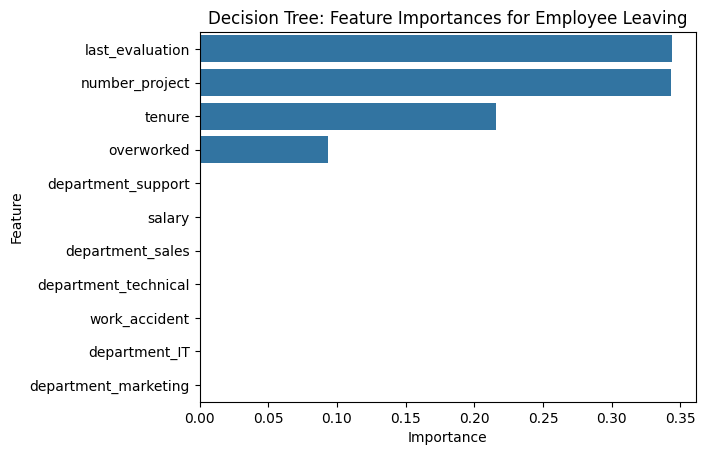

In [ ]:
sns.barplot(data=tree2_importances, x="gini_importance", y=tree2_importances.index, orient='h')
plt.title("Decision Tree: Feature Importances for Employee Leaving", fontsize=12)
plt.ylabel("Feature")
plt.xlabel("Importance")
plt.show()


The barplot above shows that in this decision tree model, `last_evaluation`, `number_project`, `tenure`, and `overworked` have the highest importance, in that order. These variables are most helpful in predicting the outcome variable, `left`.

#### Random forest feature importance


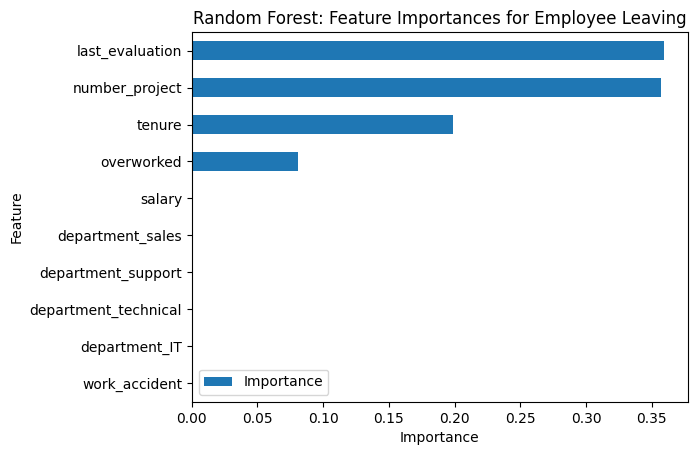

In [ ]:
# Get feature importances
feat_impt = rf2.best_estimator_.feature_importances_

# Get indices of top 10 features
ind = np.argpartition(rf2.best_estimator_.feature_importances_, -10)[-10:]

# Get column labels of top 10 features 
feat = X.columns[ind]

# Filter `feat_impt` to consist of top 10 feature importances
feat_impt = feat_impt[ind]

y_df = pd.DataFrame({"Feature":feat,"Importance":feat_impt})
y_sort_df = y_df.sort_values("Importance")
fig = plt.figure()
ax1 = fig.add_subplot(111)

y_sort_df.plot(kind='barh',ax=ax1,x="Feature",y="Importance")

ax1.set_title("Random Forest: Feature Importances for Employee Leaving", fontsize=12)
ax1.set_ylabel("Feature")
ax1.set_xlabel("Importance")

plt.show()

The plot above shows that in this random forest model, `last_evaluation`, `number_project`, `tenure`, and `overworked` have the highest importance, in that order. These variables are most helpful in predicting the outcome variable, `left`, and they are the same as the ones used by the decision tree model.

## Step 4. Results and Evaluation




### Summary of model results

**Logistic Regression**

The logistic regression model achieved precision of 80%, recall of 83%, f1-score of 80% (all weighted averages), and accuracy of 83%, on the test set.

**Tree-based Machine Learning**

After conducting feature engineering, the decision tree model achieved AUC of 93.8%, precision of 87.0%, recall of 90.4%, f1-score of 88.7%, and accuracy of 96.2%, on the test set. The random forest modestly outperformed the decision tree model. 

### Conclusion, Recommendations, Next Steps

The models and the feature importances extracted from the models confirm that employees at the company are overworked. 

To retain employees, the following recommendations could be presented to the stakeholders:

* Cap the number of projects that employees can work on.
* Consider promoting employees who have been with the company for atleast four years, or conduct further investigation about why four-year tenured employees are so dissatisfied. 
* Either reward employees for working longer hours, or don't require them to do so. 
* If employees aren't familiar with the company's overtime pay policies, inform them about this. If the expectations around workload and time off aren't explicit, make them clear. 
* Hold company-wide and within-team discussions to understand and address the company work culture, across the board and in specific contexts. 
* High evaluation scores should not be reserved for employees who work 200+ hours per month. Consider a proportionate scale for rewarding employees who contribute more/put in more effort. 

